# JHUPIEGO - RISE DATA DISCOVERY

## Import Libraries

In [1]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import os
# get parent user path
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import os
import yaml
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions

In [3]:
def check_null_values(df):
    if df is not None:
        try:
            missing_value = df.isnull().sum()
            mis_val_percent = 100 * df.isnull().sum() / len(df)
            mis_val_table = pd.concat([missing_value, mis_val_percent], axis=1)
            mis_val_table_rename_cols = mis_val_table.rename(
                columns={0: "Missing Values", 1: "% of Total Values"}
            )
            mis_val_table_rename_cols = (
                mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0]
                .sort_values("% of Total Values", ascending=False)
                .round(1)
            )
            print(
                "There are "
                + str(mis_val_table_rename_cols.shape[0])
                + " columns that have missing values"
            )
            return mis_val_table_rename_cols
        except Exception as e:
            print(f"Exception on checking missing values with error: {e}")
            
def load_excel_sheet(path: str):
    if path is not None:
        try:
            xls = pd.ExcelFile(path)
            df = xls.parse(skiprows=0)
            return df
        except Exception as e:
            print(f"Exception on loading excel spreadsheet with error: {e}")
            
def date_visit_conversion(df,visit_col: str,visit_year: str, visit_month: str):
    if df is not None:
        try:
            df = df.copy()
            df[visit_col] = pd.to_datetime(df[visit_col],errors='coerce')
            df[visit_year] = df[visit_col].dt.year
            df[visit_month] = df[visit_col].dt.month
            return df
        except Exception as e:
            print(f"Exception on converting visit date with error: {e}") 
            
def plot_visit_date(df, primary_key: str, data_name: str):
    if df is not None:
        df_sub = df.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")
        df_sub_slice = df_sub.groupby("VISIT_YEAR").agg(
            {primary_key: lambda x: x.nunique()}
        )
        df_sub_slice.reset_index(inplace=True)
        df_sub_slice["VISIT_YEAR"] = df_sub_slice["VISIT_YEAR"].astype("int")
        ax_sub = sns.barplot(x="VISIT_YEAR", y=primary_key, data=df_sub_slice)
        ax_sub.set(xlabel="Year of Visit", ylabel="Number of Patient Visits")
        ax_sub.set_title(f"'Trend of Yearly Patient Visits:{data_name}'")
        plt.xticks(rotation=60)
        
def convert_to_datetime(df,date_col: str):
    if df is not None:
        try:
            df[date_col] = pd.to_datetime(df[date_col],errors='coerce')
            return df
        except Exception as e:
            print(f"Exception on converting to datetime with error: {e}")      

def print_min_max_dates(df,date_col: str,type_date: str):
    if df is not None:
        return print(f" The earliest {type_date} date is: {df[date_col].min()}, and the most recent {type_date} date is {df[date_col].max()}") 
    
def print_num_rows_cols(df, df_name: str):
        if df is not None:
            return print(f"{df_name} data has {df.shape[1]} columns and {df.shape[0]} rows.") 

## Loading Data

In [4]:
# # Pharmacy Data
# df_nig_data = pd.read_csv("/data/rise_data/PharmacyData_Niger.csv")
# df_akw_data = load_excel_sheet("/data/rise_data/PharmacyData_Akwa Ibom.xlsx")
# df_ada_data = load_excel_sheet("/data/rise_data/PharmacyData_Adamawa.xlsx")
# df_xls_cross = load_excel_sheet("/data/rise_data/PharmacyData_Cross River.xlsx")

In [5]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [6]:
input_root = config['rise_files']['raw_data_path']
pharmacy_file = config['rise_files']['raw_pharmacy_file']
pharmacy_input = input_root + pharmacy_file
print(pharmacy_input)

/data/rise_data/concat_pharmacy_data.csv


In [7]:
#%%time
df = pd.read_csv(pharmacy_input,low_memory=False)

## Filter for ART

In [8]:
ART_LIST = ['ART First Line Adult','ART Second Line Adult','ART First Line Children','ART Second Line Children','Third Line'] 

In [9]:
df['Regimen Line'].value_counts()

ART First Line Adult                              2490734
Cotrimoxazole (CTX) Prophylaxis                    400640
Isoniazid Preventive Therapy (IPT)                 117929
ART First Line Children                             78773
ART Second Line Adult                               41530
ARV Prophylaxis for Pregnant Women                   2522
ART Second Line Children                             2232
Other anti-infectives (including STI Medicine)       2027
Other Medicines                                      1368
OI Treatment                                          845
Third Line                                            138
TB Treatment Adult                                    101
ARV Prophylaxis for Infants                            31
TB Treatment Children                                  13
Post Exposure Prophylaxis (PEP)                         4
PrEP                                                    3
Name: Regimen Line, dtype: int64

In [10]:
df= df[df['Regimen Line'].isin(ART_LIST)]

In [11]:
df['Regimen Line'].value_counts()

ART First Line Adult        2490734
ART First Line Children       78773
ART Second Line Adult         41530
ART Second Line Children       2232
Third Line                      138
Name: Regimen Line, dtype: int64

In [12]:
visits = df[['PATIENT_ID','DATE_VISIT']].groupby('PATIENT_ID').count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')

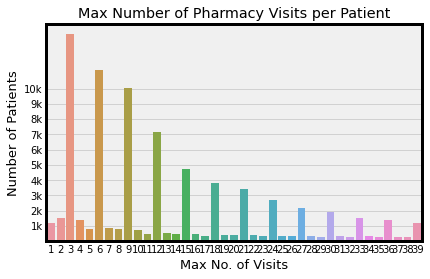

In [13]:
ave_visits1 = visits.query('DATE_VISIT < 40')
fig = sns.barplot(ave_visits1['DATE_VISIT'].astype('int'), ave_visits1['PATIENT_ID'].astype('int'))
#plt.xticks(fontsize=7)
plt.yticks(ticks=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000], labels=['1k','2k','3k','4k','5k','6k','7k','8k','9k','10k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)
plt.title('Max Number of Pharmacy Visits per Patient')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
plt.savefig("../Figures/pharmacy_visits_prededuplication.png",transparent=True)

## Check duplicates

In [14]:
df.duplicated().sum()

0

In [15]:
print(f"There are {df.loc[:, df.columns != 'PHARMACY_ID'].duplicated(subset=['DATE_VISIT','PATIENT_ID','FACILITY_ID','NEXT_APPOINTMENT','Regimen Line','Regimen','MORNING','EVENING','AFTERNOON','ADHERENCE']).sum()} duplicate rows.")

There are 1194645 duplicate rows.


In [16]:
df.groupby(['PATIENT_ID'])["PHARMACY_ID"].count().sort_values(ascending=False)

PATIENT_ID
143852    370
143759    360
150928    352
145143    342
145763    318
         ... 
92402       1
92405       1
92407       1
28990       1
93268       1
Name: PHARMACY_ID, Length: 102384, dtype: int64

In [17]:
df_check = df.groupby(['PATIENT_ID','State','DATE_VISIT','NEXT_APPOINTMENT','Regimen Line','Regimen','MORNING','AFTERNOON','EVENING'])["PHARMACY_ID"].count().sort_values(ascending=False)
df_check = df_check.rename('duplicate_counts')
df_check = df_check.reset_index()

In [18]:
df_check[df_check['duplicate_counts']>1]['State'].value_counts()

Akwa Ibom      266036
Niger          234065
Adamawa        207575
Cross River    163592
Name: State, dtype: int64

In [19]:
df_rows = df_check[df_check['duplicate_counts']>1]

In [20]:
len(df_rows)

871268

In [21]:
print(f"Before deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','FACILITY_ID','ADHERENCE','DATE_VISIT','NEXT_APPOINTMENT','Regimen','Regimen Line','MORNING','AFTERNOON','EVENING'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before deduplication the dataframe has 2613407 rows
 
After deduplication the dataframe has 1418762 rows


In [22]:
print(f"There are {df.loc[:, df.columns != 'PHARMACY_ID'].duplicated(subset=['DATE_VISIT','PATIENT_ID','NEXT_APPOINTMENT','Regimen']).sum()} duplicate rows.")

There are 498890 duplicate rows.


In [23]:
df_check2 = df.groupby(['PATIENT_ID','State','DATE_VISIT','NEXT_APPOINTMENT','Regimen Line'])["PHARMACY_ID"].count().sort_values(ascending=False)
df_check2 = df_check2.rename('duplicate_counts')
df_check2 = df_check2.reset_index()

In [24]:
print(f"Before deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','FACILITY_ID','ADHERENCE','DATE_VISIT','NEXT_APPOINTMENT','Regimen','Regimen Line','MORNING','AFTERNOON','EVENING'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before deduplication the dataframe has 1418762 rows
 
After deduplication the dataframe has 1418762 rows


In [25]:
print(f"Before secondary deduplication the dataframe has {df.shape[0]} rows")
print(" ")
df.drop_duplicates(subset=['PATIENT_ID','DATE_VISIT','NEXT_APPOINTMENT','Regimen'],inplace=True)
print(f"After deduplication the dataframe has {df.shape[0]} rows")

Before secondary deduplication the dataframe has 1418762 rows
 
After deduplication the dataframe has 919872 rows


In [26]:
visits2 = df[['PATIENT_ID','DATE_VISIT']].groupby('PATIENT_ID').count().reset_index().groupby('DATE_VISIT').count().reset_index().sort_values('DATE_VISIT')

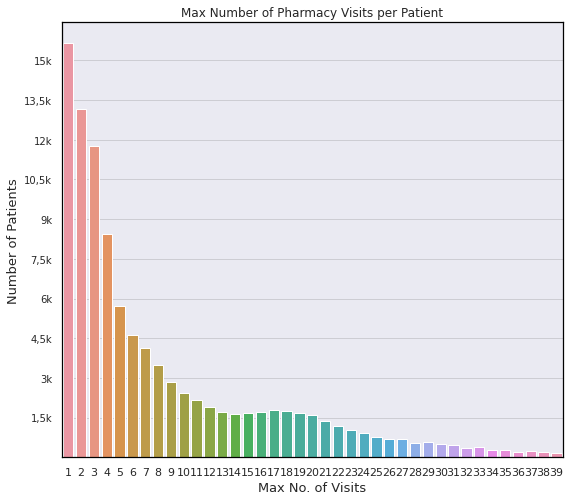

In [27]:
ave_visits2 = visits2.query('DATE_VISIT < 40')
fig = sns.barplot(ave_visits2['DATE_VISIT'].astype('int'), ave_visits2['PATIENT_ID'].astype('int'))
#plt.xticks(fontsize=7)
plt.yticks(ticks=[1500,3000,4500,6000,7500,9000,10500,12000,13500,15000], labels=['1,5k','3k','4,5k','6k','7,5k','9k','10,5k','12k','13,5k','15k'], fontsize=10)
plt.xlabel('Max No. of Visits', fontsize=13)
plt.ylabel('Number of Patients', fontsize=13)
plt.title('Max Number of Pharmacy Visits per Patient')
fig.grid(True,color='grey',linewidth = '0.9',axis='y',alpha=0.3)
fig.spines['bottom'].set_color('black')
fig.spines['top'].set_color('black') 
fig.spines['right'].set_color('black')
fig.spines['left'].set_color('black')
sns.set(rc={'figure.figsize':(8,8)})
plt.savefig("../Figures/pharmacy_visits_prededuplication_v1.png",transparent=True)

In [28]:
df_xls_cross = df.query("State == 'Cross River'")
df_ada_data = df.query("State == 'Adamawa'")
df_akw_data = df.query("State == 'Akwa Ibom'")
df_nig_data = df.query("State == 'Niger'")

## Initial Summary

### Pharmacy Data

#### Cross River

In [29]:
print_num_rows_cols(df_xls_cross,'Cross River')

Cross River data has 20 columns and 171971 rows.


In [30]:
df_xls_cross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171971 entries, 2511022 to 3138884
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   State             171971 non-null  object 
 1   L.G.A             171971 non-null  object 
 2   Facility Name     171971 non-null  object 
 3   Regimen Line      171971 non-null  object 
 4   Regimen           171971 non-null  object 
 5   PHARMACY_ID       171971 non-null  int64  
 6   PATIENT_ID        171971 non-null  int64  
 7   FACILITY_ID       171971 non-null  int64  
 8   DATE_VISIT        171971 non-null  object 
 9   DURATION          171971 non-null  int64  
 10  MORNING           171971 non-null  float64
 11  AFTERNOON         171971 non-null  float64
 12  EVENING           171971 non-null  float64
 13  ADR_SCREENED      168530 non-null  object 
 14  ADR_IDS           3 non-null       object 
 15  PRESCRIP_ERROR    171971 non-null  int64  
 16  ADHERENCE    

##### Visits Summary

In [31]:
df_cross_sub = df_xls_cross.copy()
df_cross_sub['DATE_VISIT'] = pd.to_datetime(df_cross_sub['DATE_VISIT'],errors='coerce')
df_cross_sub['DATE_VISIT'].head(3)

2511022   2019-06-05
2511023   2017-07-18
2511024   2020-04-24
Name: DATE_VISIT, dtype: datetime64[ns]

In [32]:
df_cross_sub['VISIT_YEAR'] = df_cross_sub['DATE_VISIT'].dt.year
df_cross_sub['VISIT_MONTH'] = df_cross_sub['DATE_VISIT'].dt.month

In [33]:
print(f" The earliest visit date is: {df_cross_sub['DATE_VISIT'].min()}, and the most recent date is {df_cross_sub['DATE_VISIT'].max()}")

 The earliest visit date is: 1998-07-07 00:00:00, and the most recent date is 2109-09-10 00:00:00


In [34]:
df_cross_subset = df_cross_sub.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")

In [35]:
df_cross_subset.DATE_VISIT.max()

Timestamp('2021-12-02 00:00:00')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '1998'),
  Text(1, 0, '2001'),
  Text(2, 0, '2002'),
  Text(3, 0, '2005'),
  Text(4, 0, '2006'),
  Text(5, 0, '2007'),
  Text(6, 0, '2008'),
  Text(7, 0, '2009'),
  Text(8, 0, '2010'),
  Text(9, 0, '2011'),
  Text(10, 0, '2012'),
  Text(11, 0, '2013'),
  Text(12, 0, '2014'),
  Text(13, 0, '2015'),
  Text(14, 0, '2016'),
  Text(15, 0, '2017'),
  Text(16, 0, '2018'),
  Text(17, 0, '2019'),
  Text(18, 0, '2020'),
  Text(19, 0, '2021')])

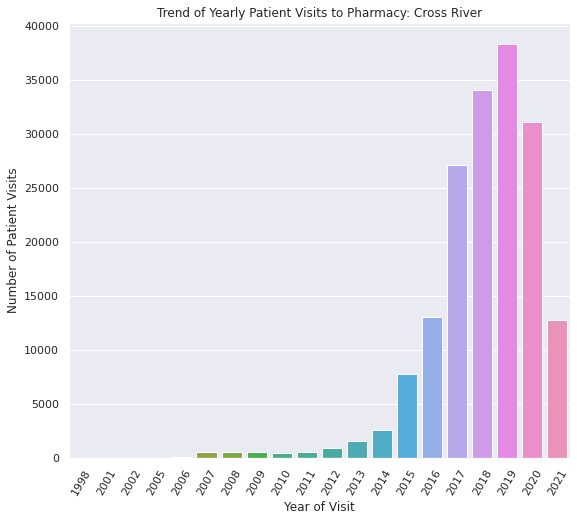

In [36]:
df_cross_slice = df_cross_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})
df_cross_slice.reset_index(inplace=True)
df_cross_slice['VISIT_YEAR'] = df_cross_slice['VISIT_YEAR'].astype('int')
ax_cross = sns.barplot(x = 'VISIT_YEAR',y='PHARMACY_ID',data=df_cross_slice)
ax_cross.set(xlabel='Year of Visit', ylabel='Number of Patient Visits')
ax_cross.set_title('Trend of Yearly Patient Visits to Pharmacy: Cross River')
plt.xticks(rotation=60)

In [37]:
df_cross_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})

PHARMACY_ID
VISIT_YEAR             
1998.0                1
2001.0                7
2002.0                3
2005.0                5
2006.0              110
2007.0              533
2008.0              516
2009.0              520
2010.0              491
2011.0              594
2012.0              966
2013.0             1544
2014.0             2625
2015.0             7768
2016.0            13024
2017.0            27097
2018.0            34034
2019.0            38310
2020.0            31052
2021.0            12747

In [38]:
df_cross_pie_regimen = df_cross_subset.groupby("Regimen")["PHARMACY_ID"].count()

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_cross_pie_regimen)

Regimen
3TC/FTC(300/300mg)+ATV/r(300/100mg)                        5
3TC/FTC(300/300mg)+EFV(600mg)                              2
3TC/FTC(300/300mg)+LPV/r(200/50mg)                         6
3TC/FTC(300/300mg)+NVP(200mg)                              3
ABC(20mg/ml)+3TC(300mg)+DTG(50mg)                        549
ABC(20mg/ml)+DDI(10mg/ml)+3TC(30mg)                        2
ABC(20mg/ml)+DDI(10mg/ml)+LPV/r(80/20mg/ml)                5
ABC(20mg/ml)+FTC(200mg)+DTG(50mg)                         11
ABC(300mg)+3TC(150mg)+ATV/r(300/100mg)                    45
ABC(300mg)+3TC(150mg)+EFV(600mg)                          37
ABC(300mg)+3TC(150mg)+LPV/r(200/50mg)                     31
ABC(300mg)+3TC(150mg)+NVP(200mg)                          58
ABC(600mg)+3TC(300mg)+DTG(50mg)                            7
ABC(60mg)+3TC(30mg)+AZT(60mg)                              7
ABC(60mg)+3TC(30mg)+DTG(50mg)                            166
ABC(60mg)+3TC(30mg)+EFV(200mg)                           191
ABC(60mg)+3TC(30

#### Adamawa

In [40]:
print_num_rows_cols(df_ada_data,'Pharmacy Adamawa')

Pharmacy Adamawa data has 20 columns and 217658 rows.


In [41]:
df_ada_data.columns

Index(['State', 'L.G.A', 'Facility Name', 'Regimen Line', 'Regimen',
       'PHARMACY_ID', 'PATIENT_ID', 'FACILITY_ID', 'DATE_VISIT', 'DURATION',
       'MORNING', 'AFTERNOON', 'EVENING', 'ADR_SCREENED', 'ADR_IDS',
       'PRESCRIP_ERROR', 'ADHERENCE', 'NEXT_APPOINTMENT', 'DMOC_TYPE',
       'BODY_WEIGHT'],
      dtype='object')

In [42]:
df_ada_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217658 entries, 1753673 to 2510992
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   State             217658 non-null  object 
 1   L.G.A             217658 non-null  object 
 2   Facility Name     217658 non-null  object 
 3   Regimen Line      217658 non-null  object 
 4   Regimen           217658 non-null  object 
 5   PHARMACY_ID       217658 non-null  int64  
 6   PATIENT_ID        217658 non-null  int64  
 7   FACILITY_ID       217658 non-null  int64  
 8   DATE_VISIT        217658 non-null  object 
 9   DURATION          217658 non-null  int64  
 10  MORNING           217658 non-null  float64
 11  AFTERNOON         217658 non-null  float64
 12  EVENING           217658 non-null  float64
 13  ADR_SCREENED      193607 non-null  object 
 14  ADR_IDS           10 non-null      object 
 15  PRESCRIP_ERROR    217658 non-null  int64  
 16  ADHERENCE    

In [43]:
df_ada_sub = df_ada_data.copy()
df_ada_sub['DATE_VISIT'] = pd.to_datetime(df_ada_sub['DATE_VISIT'],errors='coerce')
df_ada_sub['VISIT_YEAR'] = df_ada_sub['DATE_VISIT'].dt.year
df_ada_sub['VISIT_MONTH'] = df_ada_sub['DATE_VISIT'].dt.month
df_ada_sub['DATE_VISIT'].head(3)

1753673   2019-11-15
1753675   2019-11-18
1753676   2018-10-02
Name: DATE_VISIT, dtype: datetime64[ns]

In [44]:
print(f" The earliest visit date is: {df_ada_sub['DATE_VISIT'].min()}, and the most recent date is {df_ada_sub['DATE_VISIT'].max()}")

 The earliest visit date is: 1954-07-25 00:00:00, and the most recent date is 2212-03-20 00:00:00


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, '2001'),
  Text(1, 0, '2002'),
  Text(2, 0, '2003'),
  Text(3, 0, '2004'),
  Text(4, 0, '2005'),
  Text(5, 0, '2006'),
  Text(6, 0, '2007'),
  Text(7, 0, '2008'),
  Text(8, 0, '2009'),
  Text(9, 0, '2010'),
  Text(10, 0, '2011'),
  Text(11, 0, '2012'),
  Text(12, 0, '2013'),
  Text(13, 0, '2014'),
  Text(14, 0, '2015'),
  Text(15, 0, '2016'),
  Text(16, 0, '2017'),
  Text(17, 0, '2018'),
  Text(18, 0, '2019'),
  Text(19, 0, '2020'),
  Text(20, 0, '2021')])

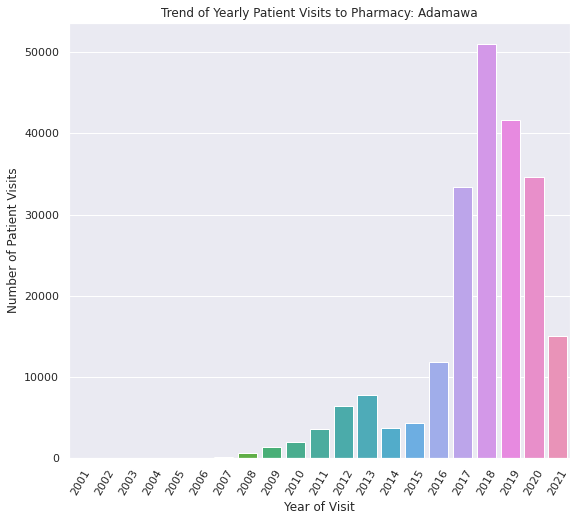

In [45]:
df_ada_subset = df_ada_sub.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")
df_ada_slice = df_ada_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})
df_ada_slice.reset_index(inplace=True)
df_ada_slice['VISIT_YEAR'] = df_ada_slice['VISIT_YEAR'].astype('int')
ax_ada = sns.barplot(x = 'VISIT_YEAR',y='PHARMACY_ID',data=df_ada_slice)
ax_ada.set(xlabel='Year of Visit', ylabel='Number of Patient Visits')
ax_ada.set_title('Trend of Yearly Patient Visits to Pharmacy: Adamawa')
plt.xticks(rotation=60)

In [46]:
df_ada_subset.DATE_VISIT.max()

Timestamp('2021-05-28 00:00:00')

In [47]:
df_pie_regimen_line = df_ada_subset.groupby("Regimen Line")["PHARMACY_ID"].count()

In [48]:
df_pie_regimen = df_ada_subset.groupby("Regimen")["PHARMACY_ID"].count()

In [49]:
df_pie_regimen_line

Regimen Line
ART First Line Adult        206553
ART First Line Children       9257
ART Second Line Adult         1697
ART Second Line Children        73
Third Line                       2
Name: PHARMACY_ID, dtype: int64

In [50]:
type(df_pie_regimen)

pandas.core.series.Series

In [51]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_pie_regimen)

Regimen
3TC/FTC(300/300mg)+ATV/r(300/100mg)                       13
3TC/FTC(300/300mg)+EFV(600mg)                            144
3TC/FTC(300/300mg)+LPV/r(200/50mg)                         8
3TC/FTC(300/300mg)+NVP(200mg)                              5
ABC(20mg/ml)+3TC(300mg)+DTG(50mg)                        469
ABC(20mg/ml)+DDI(10mg/ml)+3TC(30mg)                        2
ABC(20mg/ml)+DDI(10mg/ml)+LPV/r(80/20mg/ml)                2
ABC(20mg/ml)+FTC(200mg)+DTG(50mg)                         12
ABC(300mg)+3TC(150mg)+ATV/r(300/100mg)                    10
ABC(300mg)+3TC(150mg)+EFV(600mg)                         107
ABC(300mg)+3TC(150mg)+LPV/r(200/50mg)                     22
ABC(300mg)+3TC(150mg)+NVP(200mg)                         208
ABC(300mg)+DDI(400mg)+IDV/r(400/50mg)                      4
ABC(300mg)+DDI(400mg)+LPV/r(200/50mg)                      1
ABC(600mg)+3TC(300mg)+DTG(50mg)                           35
ABC(60mg)+3TC(30mg)+AZT(60mg)                             40
ABC(60mg)+3TC(30

In [52]:
df_ada_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})

PHARMACY_ID
VISIT_YEAR             
2001.0                6
2002.0                6
2003.0                4
2004.0                2
2005.0                6
2006.0               15
2007.0               72
2008.0              632
2009.0             1374
2010.0             1927
2011.0             3617
2012.0             6447
2013.0             7760
2014.0             3733
2015.0             4359
2016.0            11787
2017.0            33437
2018.0            51033
2019.0            41627
2020.0            34658
2021.0            15080

#### Akwa Ibom

In [53]:
print_num_rows_cols(df_akw_data,'Akwa Ibom')

Akwa Ibom data has 20 columns and 290550 rows.


In [54]:
df_akw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290550 entries, 705098 to 1753669
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   State             290550 non-null  object 
 1   L.G.A             290550 non-null  object 
 2   Facility Name     290550 non-null  object 
 3   Regimen Line      290550 non-null  object 
 4   Regimen           290550 non-null  object 
 5   PHARMACY_ID       290550 non-null  int64  
 6   PATIENT_ID        290550 non-null  int64  
 7   FACILITY_ID       290550 non-null  int64  
 8   DATE_VISIT        290550 non-null  object 
 9   DURATION          290550 non-null  int64  
 10  MORNING           290550 non-null  float64
 11  AFTERNOON         290550 non-null  float64
 12  EVENING           290550 non-null  float64
 13  ADR_SCREENED      277268 non-null  object 
 14  ADR_IDS           4 non-null       object 
 15  PRESCRIP_ERROR    290550 non-null  int64  
 16  ADHERENCE     

In [55]:
df_akw_data = df_akw_data.rename(columns={"Regimen Type": "Regimen Line"})

In the new data sets **DMOC_TYPE** and **BODY_WEIGHT** are not included, **Regimen Type** is **Regimen Line** and there is a new column **Drug**


In [56]:
columns_reorder = ["State","L.G.A","Facility Name","Regimen Line","Regimen","PHARMACY_ID","PATIENT_ID","FACILITY_ID","DATE_VISIT","DURATION","MORNING","AFTERNOON","EVENING","ADR_SCREENED","ADR_IDS","PRESCRIP_ERROR","ADHERENCE","NEXT_APPOINTMENT","DMOC_TYPE","BODY_WEIGHT"]

In [57]:
df_akw_data_copy = df_akw_data.reindex(columns=columns_reorder)

In [58]:
#df_akw_data_copy.to_csv("PharmacyData_Akwa_Ibom.csv",index=False,header=True)

In [59]:
df_akw_sub = df_akw_data.copy()
df_akw_sub['DATE_VISIT'] = pd.to_datetime(df_akw_sub['DATE_VISIT'],errors='coerce')
df_akw_sub['VISIT_YEAR'] = df_akw_sub['DATE_VISIT'].dt.year
df_akw_sub['VISIT_MONTH'] = df_akw_sub['DATE_VISIT'].dt.month

In [60]:
print(f" The earliest visit date is: {df_akw_sub['DATE_VISIT'].min()}, and the most recent date is {df_akw_sub['DATE_VISIT'].max()}")

 The earliest visit date is: 2000-08-19 00:00:00, and the most recent date is 2201-10-22 00:00:00


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, '2000'),
  Text(1, 0, '2001'),
  Text(2, 0, '2007'),
  Text(3, 0, '2008'),
  Text(4, 0, '2009'),
  Text(5, 0, '2010'),
  Text(6, 0, '2011'),
  Text(7, 0, '2012'),
  Text(8, 0, '2013'),
  Text(9, 0, '2014'),
  Text(10, 0, '2015'),
  Text(11, 0, '2016'),
  Text(12, 0, '2017'),
  Text(13, 0, '2018'),
  Text(14, 0, '2019'),
  Text(15, 0, '2020'),
  Text(16, 0, '2021')])

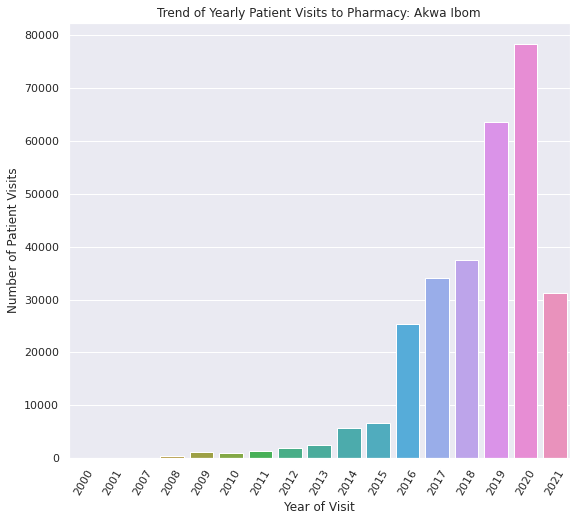

In [61]:
df_akw_subset = df_akw_sub.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")

df_akw_slice = df_akw_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})
df_akw_slice.reset_index(inplace=True)
df_akw_slice['VISIT_YEAR'] = df_akw_slice['VISIT_YEAR'].astype('int')
ax_akw = sns.barplot(x = 'VISIT_YEAR',y='PHARMACY_ID',data=df_akw_slice)
ax_akw.set(xlabel='Year of Visit', ylabel='Number of Patient Visits')
ax_akw.set_title('Trend of Yearly Patient Visits to Pharmacy: Akwa Ibom')
plt.xticks(rotation=60)

In [62]:
df_akw_pie_regimen = df_akw_subset.groupby("Regimen")["PHARMACY_ID"].count()

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_akw_pie_regimen)

Regimen
3TC/FTC(300/300mg)+ATV/r(300/100mg)                         3
3TC/FTC(300/300mg)+EFV(600mg)                               4
3TC/FTC(300/300mg)+LPV/r(200/50mg)                          3
3TC/FTC(300/300mg)+NVP(200mg)                               5
ABC(20mg/ml)+3TC(300mg)+DTG(50mg)                         401
ABC(20mg/ml)+DDI(10mg/ml)+3TC(30mg)                         1
ABC(20mg/ml)+DDI(10mg/ml)+LPV/r(80/20mg/ml)                 7
ABC(20mg/ml)+FTC(200mg)+DTG(50mg)                           9
ABC(300mg)+3TC(150mg)+ATV/r(300/100mg)                     91
ABC(300mg)+3TC(150mg)+EFV(600mg)                          206
ABC(300mg)+3TC(150mg)+LPV/r(200/50mg)                     217
ABC(300mg)+3TC(150mg)+NVP(200mg)                           54
ABC(300mg)+DDI(400mg)+LPV/r(200/50mg)                      31
ABC(600mg)+3TC(300mg)+DTG(50mg)                           160
ABC(60mg)+3TC(30mg)+AZT(60mg)                              51
ABC(60mg)+3TC(30mg)+DTG(50mg)                             338


In [64]:
df_akw_subset.DATE_VISIT.max()

Timestamp('2021-12-05 00:00:00')

In [65]:
df_akw_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})

PHARMACY_ID
VISIT_YEAR             
2000.0                2
2001.0               10
2007.0                5
2008.0              435
2009.0             1115
2010.0              915
2011.0             1348
2012.0             1812
2013.0             2408
2014.0             5724
2015.0             6611
2016.0            25377
2017.0            34133
2018.0            37433
2019.0            63649
2020.0            78369
2021.0            31174

In [66]:
df_akw_data['Regimen'].value_counts(dropna=True)

TDF(300mg)+3TC(300mg)+DTG(50mg)         154694
TDF(300mg)+3TC(300mg)+EFV(600mg)         86423
AZT(300mg)+3TC(150mg)+NVP(200mg)         30382
AZT/3TC/NVP(60/30/50mg)                   2809
AZT/3TC(300/150mg)+NVP(200mg)             2453
                                         ...  
d4T(30mg)+3TC(150mg)+LPV/r(200/50mg)         2
d4T/3TC/EFV(12/60/200mg)                     1
d4T/3TC/NVP(12/60/100mg)                     1
d4T(20mg)+3TC(10mg/ml)+EFV(200mg)            1
ABC(20mg/ml)+DDI(10mg/ml)+3TC(30mg)          1
Name: Regimen, Length: 66, dtype: int64

#### Niger

In [67]:
print_num_rows_cols(df_nig_data,'Pharmacy Niger')

Pharmacy Niger data has 20 columns and 239693 rows.


In [68]:
df_nig_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239693 entries, 0 to 701172
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   State             239693 non-null  object 
 1   L.G.A             239693 non-null  object 
 2   Facility Name     239693 non-null  object 
 3   Regimen Line      239693 non-null  object 
 4   Regimen           239693 non-null  object 
 5   PHARMACY_ID       239693 non-null  int64  
 6   PATIENT_ID        239693 non-null  int64  
 7   FACILITY_ID       239693 non-null  int64  
 8   DATE_VISIT        239693 non-null  object 
 9   DURATION          239693 non-null  int64  
 10  MORNING           239693 non-null  float64
 11  AFTERNOON         239693 non-null  float64
 12  EVENING           239693 non-null  float64
 13  ADR_SCREENED      57180 non-null   object 
 14  ADR_IDS           1 non-null       object 
 15  PRESCRIP_ERROR    239693 non-null  int64  
 16  ADHERENCE         23

##### Visits Summary

In [69]:
df_nig_sub = df_nig_data.copy()
df_nig_sub['DATE_VISIT'] = pd.to_datetime(df_nig_sub['DATE_VISIT'],errors='coerce')
df_nig_sub['DATE_VISIT'].head(3)

0   2020-03-11
1   2020-02-11
2   2021-01-14
Name: DATE_VISIT, dtype: datetime64[ns]

In [70]:
df_nig_sub['VISIT_YEAR'] = df_nig_sub['DATE_VISIT'].dt.year
df_nig_sub['VISIT_MONTH'] = df_nig_sub['DATE_VISIT'].dt.month

In [71]:
print(f" The earliest visit date is: {df_nig_sub['DATE_VISIT'].min()}, and the most recent date is {df_nig_sub['DATE_VISIT'].max()}")

 The earliest visit date is: 2000-07-11 00:00:00, and the most recent date is 2118-11-22 00:00:00


In [72]:
df_nig_subset = df_nig_sub.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")

In [73]:
df_nig_subset.DATE_VISIT.max()

Timestamp('2021-12-06 00:00:00')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '2000'),
  Text(1, 0, '2001'),
  Text(2, 0, '2004'),
  Text(3, 0, '2006'),
  Text(4, 0, '2007'),
  Text(5, 0, '2008'),
  Text(6, 0, '2009'),
  Text(7, 0, '2010'),
  Text(8, 0, '2011'),
  Text(9, 0, '2012'),
  Text(10, 0, '2013'),
  Text(11, 0, '2014'),
  Text(12, 0, '2015'),
  Text(13, 0, '2016'),
  Text(14, 0, '2017'),
  Text(15, 0, '2018'),
  Text(16, 0, '2019'),
  Text(17, 0, '2020'),
  Text(18, 0, '2021')])

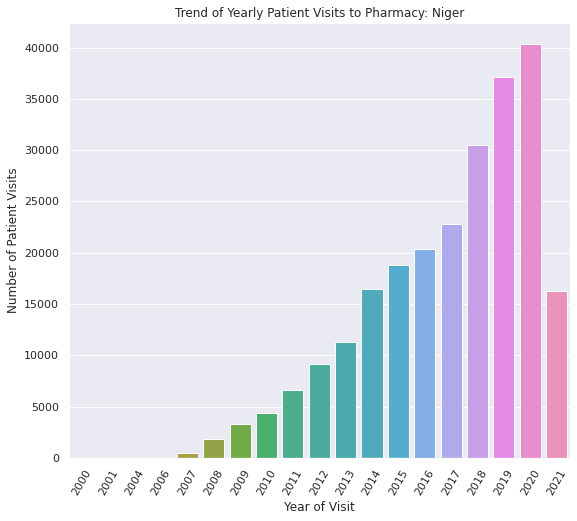

In [74]:
df_nig_slice = df_nig_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})
df_nig_slice.reset_index(inplace=True)
df_nig_slice['VISIT_YEAR'] = df_nig_slice['VISIT_YEAR'].astype('int')
ax_niger = sns.barplot(x = 'VISIT_YEAR',y='PHARMACY_ID',data=df_nig_slice)
ax_niger.set(xlabel='Year of Visit', ylabel='Number of Patient Visits')
ax_niger.set_title('Trend of Yearly Patient Visits to Pharmacy: Niger')
plt.xticks(rotation=60)

In [75]:
df_nig_subset.groupby('VISIT_YEAR').agg({'PHARMACY_ID':lambda x: x.nunique()})

PHARMACY_ID
VISIT_YEAR             
2000.0                1
2001.0                3
2004.0                2
2006.0                9
2007.0              445
2008.0             1848
2009.0             3333
2010.0             4365
2011.0             6635
2012.0             9154
2013.0            11267
2014.0            16428
2015.0            18799
2016.0            20403
2017.0            22762
2018.0            30462
2019.0            37140
2020.0            40353
2021.0            16236

#### Total Visits Calculation

In [76]:
len(df)

919872

In [77]:
df_pharm = df.copy()
df_pharm['DATE_VISIT'] = pd.to_datetime(df_pharm['DATE_VISIT'],errors='coerce')
df_pharm['NEXT_APPOINTMENT'] = pd.to_datetime(df_pharm['NEXT_APPOINTMENT'],errors='coerce')

In [78]:
len(df_pharm)

919872

### Days between Next Apoointment and Pharmacy

In [79]:
df_pharm['VISIT_APPOINTMENT_DAYS'] = df_pharm['NEXT_APPOINTMENT'] - df_pharm['DATE_VISIT']
df_pharm['VISIT_APPOINTMENT_DAYS_ACTUAL'] = df_pharm['VISIT_APPOINTMENT_DAYS']/np.timedelta64(1, 'D')

In [80]:
print(f" There are {df_pharm.VISIT_APPOINTMENT_DAYS_ACTUAL.isnull().sum()} with no next appointment dates")

 There are 3640 with no next appointment dates


In [81]:
df_pharm['VISIT_APPOINTMENT_DAYS_ACTUAL'] = df_pharm['VISIT_APPOINTMENT_DAYS_ACTUAL'].fillna(0.0)

In [82]:
df_pharm['VISIT_APPOINTMENT_DAYS_ACTUAL'] = df_pharm['VISIT_APPOINTMENT_DAYS_ACTUAL'].astype('int')

Text(0.5, 1.0, 'Distribution of Days between Pharmacy Visit and Next Appointment')

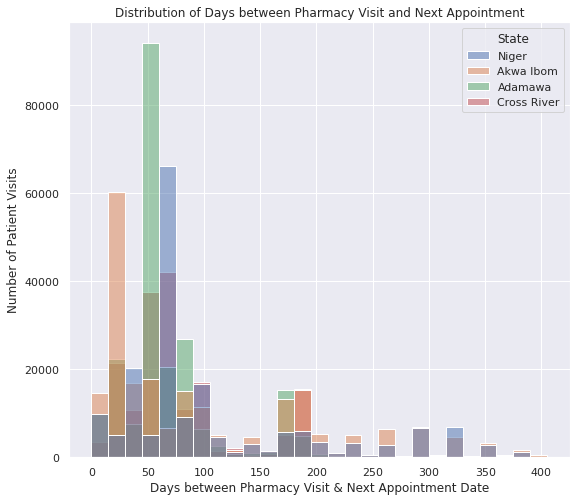

In [83]:
df_pharm_plot = df_pharm.query("VISIT_APPOINTMENT_DAYS_ACTUAL >= 0 and VISIT_APPOINTMENT_DAYS_ACTUAL <= 400")
ax_pharm = sns.histplot(data=df_pharm_plot, x="VISIT_APPOINTMENT_DAYS_ACTUAL",hue="State",binwidth=15)
ax_pharm.set(xlabel='Days between Pharmacy Visit & Next Appointment Date', ylabel='Number of Patient Visits')
ax_pharm.set_title("Distribution of Days between Pharmacy Visit and Next Appointment")

In [85]:
print(f"There are {len(df_pharm.query('VISIT_APPOINTMENT_DAYS_ACTUAL < 0'))} pharmacy entries below 0 days\n and there are {len(df_pharm.query('VISIT_APPOINTMENT_DAYS_ACTUAL > 400'))} pharmacy entries where difference between visit day and next appointment date is greater than 400 days")

There are 123161 pharmacy entries below 0 days
 and there are 6509 pharmacy entries where difference between visit day and next appointment date is greater than 400 days


In [88]:
df_pharm_plot.State.value_counts()

Akwa Ibom      220234
Adamawa        215140
Niger          183929
Cross River    170899
Name: State, dtype: int64

#### Pharmacy Averages 

In [87]:
print(f" Median diff: {round(df_pharm_plot.VISIT_APPOINTMENT_DAYS_ACTUAL.median(),2)}")
print(f" Mean diff: {round(df_pharm_plot.VISIT_APPOINTMENT_DAYS_ACTUAL.mean(),2)}")

 Median diff: 60.0
 Mean diff: 89.4


In [89]:
round(df_pharm_plot.groupby('State')['VISIT_APPOINTMENT_DAYS_ACTUAL'].mean(),2)

State
Adamawa         70.23
Akwa Ibom      104.64
Cross River     76.94
Niger          105.15
Name: VISIT_APPOINTMENT_DAYS_ACTUAL, dtype: float64

In [90]:
df_count = round(df_pharm_plot.groupby('State')['VISIT_APPOINTMENT_DAYS_ACTUAL'].mean(),2)

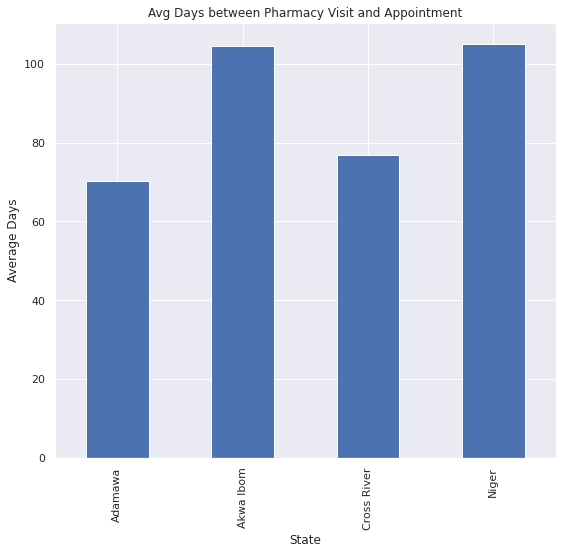

In [91]:
p1 = df_count.plot(kind='bar', title='Avg Days between Pharmacy Visit and Appointment',ylabel='Average Days')

In [92]:
round(df_pharm_plot.groupby('State')['VISIT_APPOINTMENT_DAYS_ACTUAL'].median(),2)

State
Adamawa        56
Akwa Ibom      60
Cross River    61
Niger          60
Name: VISIT_APPOINTMENT_DAYS_ACTUAL, dtype: int64